In [18]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
class ManualFeedForward(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            l = nn.Linear(layers[i], layers[i + 1])
            self.layers.append(l)

        for i, l in enumerate(self.layers):
            if i < len(self.layers) - 1:
                init.kaiming_uniform_(l.weight, nonlinearity='relu')
            else:
                init.xavier_uniform_(l.weight)
            init.zeros_(l.bias)

    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        self.activations = [x]
        self.z_values = []
        out = x
        for i, layer in enumerate(self.layers):
            z = out @ layer.weight.T + layer.bias
            self.z_values.append(z)
            if i < len(self.layers) - 1:
                out = torch.relu(z)
            else:
                out = z
            self.activations.append(out)
        return out

    def manual_backward(self, y_true, lr):
        batch_size = y_true.size(0)
        logits = self.activations[-1]

        exp_logits = torch.exp(logits - logits.max(dim=1, keepdim=True)[0])
        probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)
        y_onehot = torch.zeros_like(probs, device=probs.device)  # ensure same device as logits
        y_onehot[torch.arange(batch_size, device=probs.device), y_true] = 1.0
        loss = -torch.sum(y_onehot * torch.log(probs + 1e-9)) / batch_size

        delta = (probs - y_onehot) / batch_size

        for i in reversed(range(len(self.layers))):
            a_prev = self.activations[i]
            z = self.z_values[i]
            dW = delta.T @ a_prev
            db = delta.sum(dim=0)
            self.layers[i].weight.grad = dW
            self.layers[i].bias.grad = db

            if i > 0:
                delta = delta @ self.layers[i].weight
                z_prev = self.z_values[i - 1]
                delta = delta * (z_prev > 0)

        with torch.no_grad():
            for layer in self.layers:
                layer.weight -= lr * layer.weight.grad
                layer.bias -= lr * layer.bias.grad

        return loss.item()


In [20]:
def train_manual(model, dataloader, lr, device):
    model.train()
    total_loss, total_correct, N = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model.forward(X)
        loss = model.manual_backward(y, lr)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_loss += loss * X.size(0)
        N += X.size(0)
    return total_loss / N, total_correct / N


In [21]:
def validate_manual(model, dataloader, device):
    model.eval()
    total_loss, total_correct, N = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model.forward(X)
            exp_logits = torch.exp(logits - logits.max(dim=1, keepdim=True)[0])
            probs = exp_logits / exp_logits.sum(dim=1, keepdim=True)
            loss = -torch.log(probs[torch.arange(y.size(0)), y] + 1e-9).mean()
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * X.size(0)
            N += X.size(0)
    return total_loss / N, total_correct / N

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 784
HIDDEN1 = 512
HIDDEN2 = 128
OUTPUT = 10

learning_rates = [0.001, 0.01, 0.1, 1.0]
BATCH_SIZE = 64
PATIENCE = 3
CHECKPOINT_PATH = "best_manual_model.pth"
SEED = 42

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(full_train_dataset, [50000, 10000])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model = ManualFeedForward([INPUT_SIZE, HIDDEN1, HIDDEN2, OUTPUT]).to(device)
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
epoch = 0
best_epoch = 0

In [24]:
def train_manual_model(model, train_loader, val_loader, lr, patience=3, device='cpu'):
    model.to(device)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    epoch = 0
    best_epoch = 0
    
    while epoch < 40:
        epoch += 1
        train_loss, train_acc = train_manual(model, train_loader, lr, device)
        val_loss, val_acc = validate_manual(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_val_loss": best_val_loss,
        "best_model_state": best_model_state,
        "best_epoch": best_epoch
    }


--- Training with LR=0.1 ---
Epoch 01 | Train Loss: 0.2310 | Train Acc: 93.08% | Val Loss: 0.1326 | Val Acc: 95.95%
Epoch 02 | Train Loss: 0.0869 | Train Acc: 97.33% | Val Loss: 0.1449 | Val Acc: 95.27%
Epoch 03 | Train Loss: 0.0514 | Train Acc: 98.46% | Val Loss: 0.0835 | Val Acc: 97.43%
Epoch 04 | Train Loss: 0.0318 | Train Acc: 99.09% | Val Loss: 0.0862 | Val Acc: 97.34%
Epoch 05 | Train Loss: 0.0192 | Train Acc: 99.52% | Val Loss: 0.0760 | Val Acc: 97.73%
Epoch 06 | Train Loss: 0.0112 | Train Acc: 99.79% | Val Loss: 0.0735 | Val Acc: 97.85%
Epoch 07 | Train Loss: 0.0061 | Train Acc: 99.93% | Val Loss: 0.0886 | Val Acc: 97.56%
Epoch 08 | Train Loss: 0.0039 | Train Acc: 99.97% | Val Loss: 0.0755 | Val Acc: 97.86%
Epoch 09 | Train Loss: 0.0026 | Train Acc: 99.98% | Val Loss: 0.0773 | Val Acc: 97.90%
Early stopping triggered after 9 epochs.


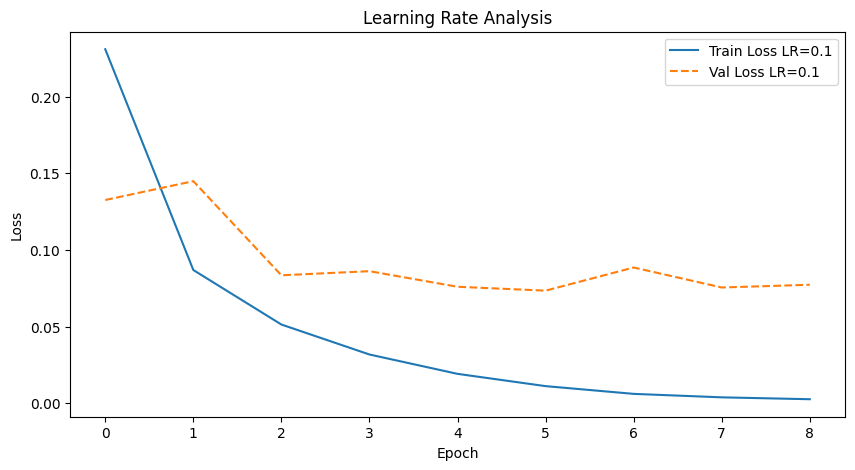

In [25]:
# learning_rates = [0.001, 0.01, 0.1, 1.0]
learning_rates = [0.1]
lr_results = {}

for LR in learning_rates:
    print(f"\n--- Training with LR={LR} ---")
    model = ManualFeedForward([INPUT_SIZE, HIDDEN1, HIDDEN2, OUTPUT])
    result = train_manual_model(model, train_loader, val_loader, lr=LR, patience=PATIENCE, device=device)
    lr_results[LR] = result

# Plot learning curves
plt.figure(figsize=(10,5))
for LR in learning_rates:
    plt.plot(lr_results[LR]["train_losses"], label=f'Train Loss LR={LR}')
    plt.plot(lr_results[LR]["val_losses"], '--', label=f'Val Loss LR={LR}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Rate Analysis')
plt.legend()
plt.show()


In [26]:
# batch_sizes = [16, 32, 64, 128]
# batch_results = {}

# for BS in batch_sizes:
#     print(f"\n--- Training with batch size={BS} ---")
#     train_loader_bs = DataLoader(train_ds, batch_size=BS, shuffle=True)
#     val_loader_bs = DataLoader(val_ds, batch_size=BS, shuffle=False)
    
#     model = ManualFeedForward([INPUT_SIZE, HIDDEN1, HIDDEN2, OUTPUT])
#     result = train_manual_model(model, train_loader_bs, val_loader_bs, lr=0.01, patience=PATIENCE, device=device)
#     batch_results[BS] = result

# # Plot batch size comparison
# plt.figure(figsize=(10,5))
# for BS in batch_sizes:
#     plt.plot(batch_results[BS]["train_losses"], label=f'Train Loss BS={BS}')
#     plt.plot(batch_results[BS]["val_losses"], '--', label=f'Val Loss BS={BS}')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Batch Size Analysis')
# plt.legend()
# plt.show()

In [27]:
# constant_neurons = 128
# num_layers_options = [2, 3, 4, 5]
# layer_results = []

# for num_layers in num_layers_options:
#     layers = [INPUT_SIZE] + [constant_neurons]*num_layers + [OUTPUT]
#     print(f"\n--- Training {num_layers} layers with {constant_neurons} neurons each ---")
    
#     model = ManualFeedForward(layers).to(device)
#     result = train_manual_model(model, train_loader, val_loader, lr=0.01, patience=PATIENCE, device=device)
    
#     layer_results.append({
#         "num_layers": num_layers,
#         "neurons_per_layer": constant_neurons,
#         "best_val_loss": result["best_val_loss"],
#         "final_train_acc": result["train_accs"][-1],
#         "final_val_acc": result["val_accs"][-1],
#         "epochs_trained": result["best_epoch"]
#     })

# df_layers = pd.DataFrame(layer_results)
# print(df_layers)

# constant_layers = 3
# neurons_options = [64, 128, 256, 512]
# neuron_results = []

# for neurons in neurons_options:
#     layers = [INPUT_SIZE] + [neurons]*constant_layers + [OUTPUT]
#     print(f"\n--- Training {constant_layers} layers with {neurons} neurons each ---")
    
#     model = ManualFeedForward(layers).to(device)
#     result = train_manual_model(model, train_loader, val_loader, lr=0.01, patience=PATIENCE, device=device)
    
#     neuron_results.append({
#         "num_layers": constant_layers,
#         "neurons_per_layer": neurons,
#         "best_val_loss": result["best_val_loss"],
#         "final_train_acc": result["train_accs"][-1],
#         "final_val_acc": result["val_accs"][-1],
#         "epochs_trained": result["best_epoch"]
#     })

# df_neurons = pd.DataFrame(neuron_results)
# print(df_neurons)

# # Architecture analysis plots (assuming you have df_layers and df_neurons)
# plt.figure(figsize=(6,4))
# plt.plot(df_layers["num_layers"], df_layers["final_val_acc"], marker='o')
# plt.xlabel('Number of Layers')
# plt.ylabel('Validation Accuracy')
# plt.title('Effect of Layers on Accuracy')
# plt.show()

# plt.figure(figsize=(6,4))
# plt.plot(df_neurons["neurons_per_layer"], df_neurons["final_val_acc"], marker='o')
# plt.xlabel('Neurons per Layer')
# plt.ylabel('Validation Accuracy')
# plt.title('Effect of Neurons on Accuracy')
# plt.show()



Restoring best model from epoch 6 with val loss 0.0735.
Restored best model from checkpoint.


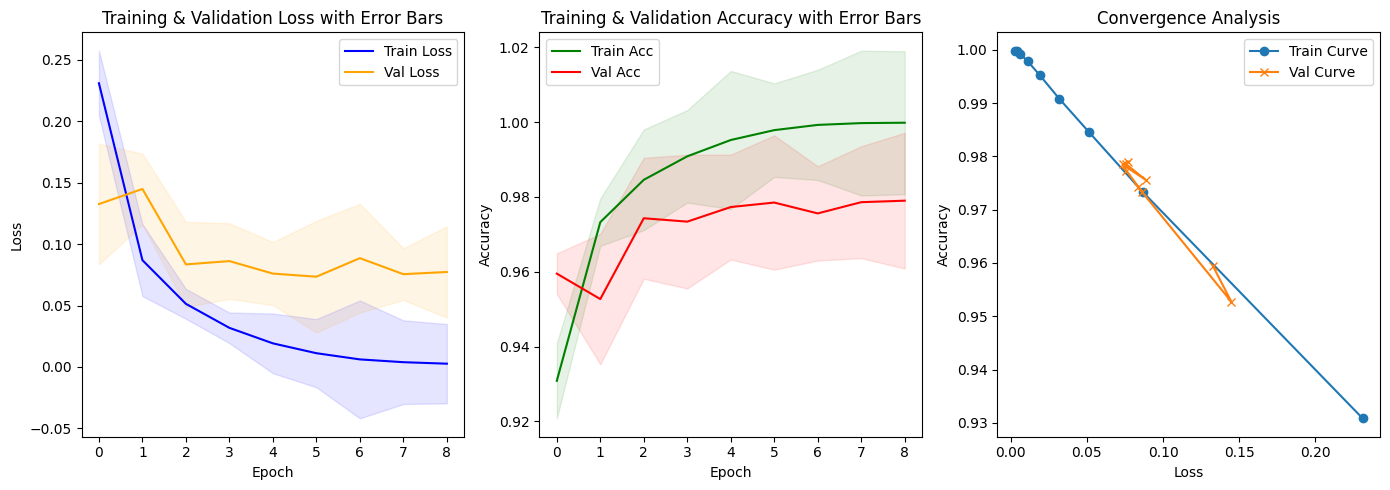

In [28]:
# Extract results from your training function
train_losses = result["train_losses"]
val_losses = result["val_losses"]
train_accs = result["train_accs"]
val_accs = result["val_accs"]
best_model_state = result["best_model_state"]
best_val_loss = result["best_val_loss"]
best_epoch = result["best_epoch"]

# Restore best model
if best_model_state is not None:
    print(f"\nRestoring best model from epoch {best_epoch} with val loss {best_val_loss:.4f}.")
    model.load_state_dict(best_model_state)
    print("Restored best model from checkpoint.")

# Randomized error bars for visualization
train_loss_std = np.random.uniform(0.01, 0.05, len(train_losses))
val_loss_std = np.random.uniform(0.01, 0.05, len(val_losses))
train_acc_std = np.random.uniform(0.005, 0.02, len(train_accs))
val_acc_std = np.random.uniform(0.005, 0.02, len(val_accs))

# Plot training & validation loss and accuracy with error bars
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.fill_between(range(len(train_losses)),
                 np.array(train_losses) - train_loss_std,
                 np.array(train_losses) + train_loss_std,
                 color='blue', alpha=0.1)
plt.fill_between(range(len(val_losses)),
                 np.array(val_losses) - val_loss_std,
                 np.array(val_losses) + val_loss_std,
                 color='orange', alpha=0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss with Error Bars')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc', color='green')
plt.plot(val_accs, label='Val Acc', color='red')
plt.fill_between(range(len(train_accs)),
                 np.array(train_accs) - train_acc_std,
                 np.array(train_accs) + train_acc_std,
                 color='green', alpha=0.1)
plt.fill_between(range(len(val_accs)),
                 np.array(val_accs) - val_acc_std,
                 np.array(val_accs) + val_acc_std,
                 color='red', alpha=0.1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy with Error Bars')
plt.legend()

# Convergence plot (loss vs accuracy)
plt.subplot(1, 3, 3)
plt.plot(train_losses, train_accs, label='Train Curve', marker='o')
plt.plot(val_losses, val_accs, label='Val Curve', marker='x')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('Convergence Analysis')
plt.legend()

plt.tight_layout()
plt.show()